In [1]:
"""
From a Re-exposure forgetting experiment dump, make a plot.
"""
import os
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 1000)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
# CSV contents
"""
"Name","analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim","finished_run","Runtime","Created","Tags","State","analyze_action_batch/LOOKBACK_STEP_1/fast_current_grad_norm","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_10/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_2/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_3/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_4/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_5/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_6/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_7/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_8/slow_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_9/slow_grad_cos_sim/mean"
"Finetuning_2022-10-23_00-16-33_UID409ff3de-1717-4087-9df8-00051301df07","-0.0019373403862118727","true","1162","2022-10-23T07:16:38.000Z","","finished","2.239533597230911","0.0336830807665506","0.014233720023185016","0.03766310271650147","-0.001937340386211872","0.09293411605213084","0.03505464717745781","0.13150217980861603","0.03802125975489616","0.037880705464724086","-0.0022483963519334795","0.017817473531446883","-0.005977238714694977","0.01060310390912928","0.019208539742976427","0.03671855771537849","0.05129895025165752","0.06192919372650924","0.07731795087456703","0.010442271593500111","0.019942822214215995","0.026647943624198273","-0.02123855147510767","0.020440528932499293","-0.014648709871107711","0.05624792933050897","-0.04488408658653498","0.08250129906843537","-0.06285883150994778","0.020526477866801365","-0.01436788754654117","0.023721244088886057","0.02438567946664989","0.01710470116216771","0.016157741099596022","0.04807755629504035","0.03746244413778186","0.09011051563855936","0.07034705230034888","0.017320275099077864","0.01624063020572066","0.01720435402261865","0.027873657830059528","0.018310485245211804","0.022337071469519288","0.06736883055318472","0.02728413636796177","0.10317704280444022","0.007898645102977752","0.018446930624970916","0.022165818384382873","0.02150447022576512","0.01921622417867184","0.02017497820738975","0.02496297657489777","0.04501228655806509","0.05270785130560398","0.08106628467566619","0.0865092396736145","0.020320206511068455","0.02521064952015877","0.013423881129119457","0.015512919798493386","0.015592196077350065","-0.0039779818383976805","0.03744639908278767","0.026403792016208173","0.06547757594097421","0.06299820812419057","0.015728452874595653","-0.004381639184430242","0.01917125706350005","-0.02966183256357908","0.017075300248885487","-0.010020184726454318","0.04852329238563124","-0.0010571113787591457","0.07316457579165908","-0.001922490168362856","0.017435287871233884","-0.009386816411279142","0.017008735999116422","0.0008225978817790747","0.016229206577621523","-0.0006647697184234844","0.04172945642783073","0.02826033877208829","0.07057756411979231","0.0561706118285656","0.01650274014658206","-0.000750996335409583","0.030538594653075724","0.04897237606346607","0.030323043633354356","0.005519177205860613","0.07288595546145436","0.04154582004994154","0.10534045834938786","0.04773182305507362","0.03039822844232679","0.004487238451838493"
"""

'\n"Name","analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim","finished_run","Runtime","Created","Tags","State","analyze_action_batch/LOOKBACK_STEP_1/fast_current_grad_norm","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/fast_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/fast_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/feat_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/full_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/full_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/head_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/head_grad_cos_sim/mean","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/slow_grad_cos_sim/SE","adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_1/slow_grad_cos_s

In [3]:
# Open wandb downloaded csv
csv_dirname = '/home/matthiasdelange/sftp_remote_projects/ContextualOracle_Matthias/adhoc_results'
csv_filename = "wandb_export_2022-10-23T15_13_53.325-07_00.csv"

csv_path = os.path.join(csv_dirname, csv_filename)
round_digits = 3
model_parts = ["full", "slow", "fast", "head", "feat", ]
# model_parts = ['head']

orig_df = pd.read_csv(csv_path)

# FILTER
# orig_df = orig_df.loc[(orig_df['SOLVER.BASE_LR'] == 0.001) & (orig_df['SOLVER.NESTEROV'] == True)]
# orig_df = orig_df.loc[(orig_df['SOLVER.NESTEROV'] == False)]  # TODO: Set to False or True to get both parts
# orig_df = orig_df.loc[(orig_df['SOLVER.MOMENTUM'] == 0)]  # TODO: Set to False or True to get both parts
# orig_df.sort_values(inplace=True, axis=0, by=['SOLVER.MOMENTUM', 'SOLVER.BASE_LR'])

# Place here in order you want the latex columns to be

# Reformat cols to have per metric, the SE and mean in separate columns, and 1->10 in rows, take 'steps' as another column
df_dict_list = []
for nb_steps_lookback in range(1, 11):  # 1 row per step
    single_df_row_dict = {'step': nb_steps_lookback, }

    for model_part in model_parts:
        mean = orig_df[
            f"adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_{nb_steps_lookback}/{model_part}_grad_cos_sim/mean"].to_list()[0]
        SE = orig_df[
            f"adhoc_users_aggregate/analyze_action_batch/LOOKBACK_STEP_{nb_steps_lookback}/{model_part}_grad_cos_sim/SE"].to_list()[0]

        single_df_row_dict[f"adhoc_users_aggregate/analyze_action_batch/{model_part}_grad_cos_sim/mean"] = mean
        single_df_row_dict[f"adhoc_users_aggregate/analyze_action_batch/{model_part}_grad_cos_sim/SE"] = SE

    # Update
    df_dict_list.append(single_df_row_dict)

transformed_df = pd.DataFrame(df_dict_list)
transformed_df.set_index('step',inplace=True) # Set step as index (for plotting later)

transformed_df

,adhoc_users_aggregate/analyze_action_batch/full_grad_cos_sim/mean,adhoc_users_aggregate/analyze_action_batch/full_grad_cos_sim/SE,adhoc_users_aggregate/analyze_action_batch/slow_grad_cos_sim/mean,adhoc_users_aggregate/analyze_action_batch/slow_grad_cos_sim/SE,adhoc_users_aggregate/analyze_action_batch/fast_grad_cos_sim/mean,adhoc_users_aggregate/analyze_action_batch/fast_grad_cos_sim/SE,adhoc_users_aggregate/analyze_action_batch/head_grad_cos_sim/mean,adhoc_users_aggregate/analyze_action_batch/head_grad_cos_sim/SE,adhoc_users_aggregate/analyze_action_batch/feat_grad_cos_sim/mean,adhoc_users_aggregate/analyze_action_batch/feat_grad_cos_sim/SE
step,,,,,,,,,,
1,0.035055,0.092934,-0.002248,0.037881,0.014234,0.033683,0.038021,0.131502,-0.001937,0.037663
2,-0.044884,0.056248,-0.014368,0.020526,-0.021239,0.026648,-0.062859,0.082501,-0.014649,0.020441
3,0.037462,0.048078,0.016241,0.017320,0.024386,0.023721,0.070347,0.090111,0.016158,0.017105
4,0.027284,0.067369,0.022166,0.018447,0.027874,0.017204,0.007899,0.103177,0.022337,0.018310
5,0.052708,0.045012,0.025211,0.020320,0.019216,0.021504,0.086509,0.081066,0.024963,0.020175
6,0.026404,0.037446,-0.004382,0.015728,0.015513,0.013424,0.062998,0.065478,-0.003978,0.015592
7,-0.001057,0.048523,-0.009387,0.017435,-0.029662,0.019171,-0.001922,0.073165,-0.010020,0.017075
8,0.028260,0.041729,-0.000751,0.016503,0.000823,0.017009,0.056171,0.070578,-0.000665,0.016229
9,0.041546,0.072886,0.004487,0.030398,0.048972,0.030539,0.047732,0.105340,0.005519,0.030323


<AxesSubplot:xlabel='step'>

[Text(0.5, 0, '$k$'), Text(0, 0.5, '$\\cos_\\angle (g_t, \\  g_{t-k})$')]

Saving at: ../imgs/SGD_GRAD_ANALYSIS/2022-10-26_17-37-56_SGD_GRAD_ANALYSIS/SGD_GRAD_ANALYSIS.pdf


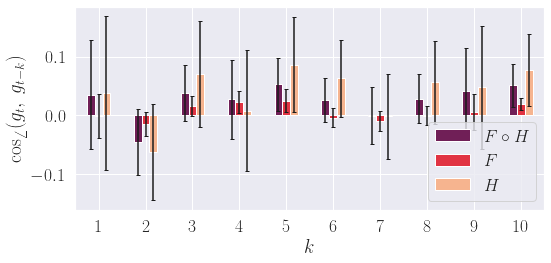

In [14]:
import datetime
import numpy as np
import seaborn as sns
# sns.set_theme(style="whitegrid")


# Append mean/SE afterwards
plot_df = transformed_df
GROUPS_TO_PLOT={ # Map to y-label
    'adhoc_users_aggregate/analyze_action_batch/full_grad_cos_sim':r'$F \circ H$',
    'adhoc_users_aggregate/analyze_action_batch/feat_grad_cos_sim':r'$F$',
    'adhoc_users_aggregate/analyze_action_batch/head_grad_cos_sim':r'$H$',
}

# Apply the default theme
# sns.set_context("paper")
# sns.set_theme(rc={
#     'font.family':'DeJavu Serif',
#     'font.serif': 'Times New Roman',
#     'font.size':30,
# })
sns.set(font_scale=1.6)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 18

# Use latex in mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

# Set latex font in mpl
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


# Save config
title = "SGD_GRAD_ANALYSIS"
main_outdir = f"../imgs/{title}"
parent_dirname = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + title
parent_dirpath = os.path.join(main_outdir, parent_dirname)

# Plot configs
plot_config = {
    "color": 'royalblue',
    "dpi": 600,
    "figsize": (8,4),
    "xlabel": "re-exposure iterations",
    "ylabel": "",
    "title": None
}

colors = [
    sns.color_palette("rocket")[1],
    sns.color_palette("rocket")[3],
    sns.color_palette("rocket")[5],
#     sns.color_palette("Spectral",10)[0],
#         sns.color_palette("Spectral",10)[9],
#         sns.color_palette("Paired")[2],
]



# Use DF pandas plot
# See: https://stackoverflow.com/questions/23144784/plotting-error-bars-on-grouped-bars-in-pandas

# convert the std columns to an array

yerr_names = []
y_names = []
legend_names = []
for name, legend_name in GROUPS_TO_PLOT.items():
    yerr_names.append(f"{name}/SE")
    y_names.append(f"{name}/mean")
    legend_names.append(legend_name)

yerr = plot_df[yerr_names].to_numpy().T

fig, ax = plt.subplots(figsize=plot_config['figsize'])
plot_df[y_names].plot(kind='bar', yerr=yerr, alpha=1, error_kw=dict(ecolor='k'),ax=ax,capsize=2,rot=0, color=colors)

ax.legend([r"$F \circ H$",r"$F$",r"$H$"]);
ax.set(xlabel=r'$k$', ylabel=r'$\cos_\angle (g_t, \  g_{t-k})$')


ax.legend(legend_names,
         loc='lower right',ncol=1
         );

plt.tight_layout()
filename = f'{title}.pdf'
filepath = os.path.join(parent_dirpath,filename)
print(f"Saving at: {filepath}")
os.makedirs(parent_dirpath, exist_ok=True)
fig.savefig(filepath)

plt.show()
plt.close('all')
